# Photometry of processed CCD images

In this notebook, we'll go over how to measure the amount of light we received from a star.

Measuring the amount of received light is known as _photometry_.

Learning goals are:
 
  * Learn to measure a star's light from a CCD image
  * Gain further insight into uncertainty and error propagation
  

# Index
* [Q1 - Uncertainty on Sky Backgroud](#Q1)
* [Q2 - What is the color of the sky?](#Q2)
* [Q3 - magnitude error](#Q3)
* [Q4 - relative error contributions](#Q4)
* [Optimizing Our Measurement](#Optimizing-our-Measurement)
* [Systematic Errors](#Systematic-Errors)
* [Masked SNR](#Masked-SNR)
* [Multi-star](#Photometry---not-just-single-star!)
* [EXERCISE - DIY](#Exercise:-Obtain-flux-measurements-for-two-more-stars)
* [Functions](#Programming-more-efficiently)
* [EXERCISE - use the functions](#Exercise:-Use-the-function-to-repeat-the-exercise-on-another-two-stars)

In [1]:
%matplotlib

Using matplotlib backend: <object object at 0x106947030>


In [1]:
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower' # make images display right-side-up
pl.style.use('dark_background')

## Step 1: Load the data

We want to perform photometry on _reduced_, fully-processed data.  We'll start by loading up the data we processed as part of the single-frame reduction exercise.

In [2]:
from astropy.io import fits
import os

In [3]:
# on my computer, the data are in a subdirectory called 'data/', so I chdir there
os.chdir('data_mar8_2021/')

In [4]:
pleiades_clear_darksub_flattened = fits.getdata('pleiades_30s_C_other_001_darksub_flattened.fits')
pleiades_clear_darksub_flattened_uncertainty = fits.getdata('pleiades_30s_C_other_001_darksub_flattened_uncertainty.fits')

Quick consistency check:  Make sure these numbers match up.  If either of these numbers are not correct, you need to go back and re-run the Data Reduction - Single Frame notebook.

In [5]:
print(f"This value: {pleiades_clear_darksub_flattened_uncertainty[50,50]:0.2f} should be 39.72")
print(f"This value: {pleiades_clear_darksub_flattened[50,50]:0.2f} should be 952.24")

This value: 39.72 should be 39.72
This value: 952.24 should be 952.24


As usual, the first thing we do is display & inspect the data

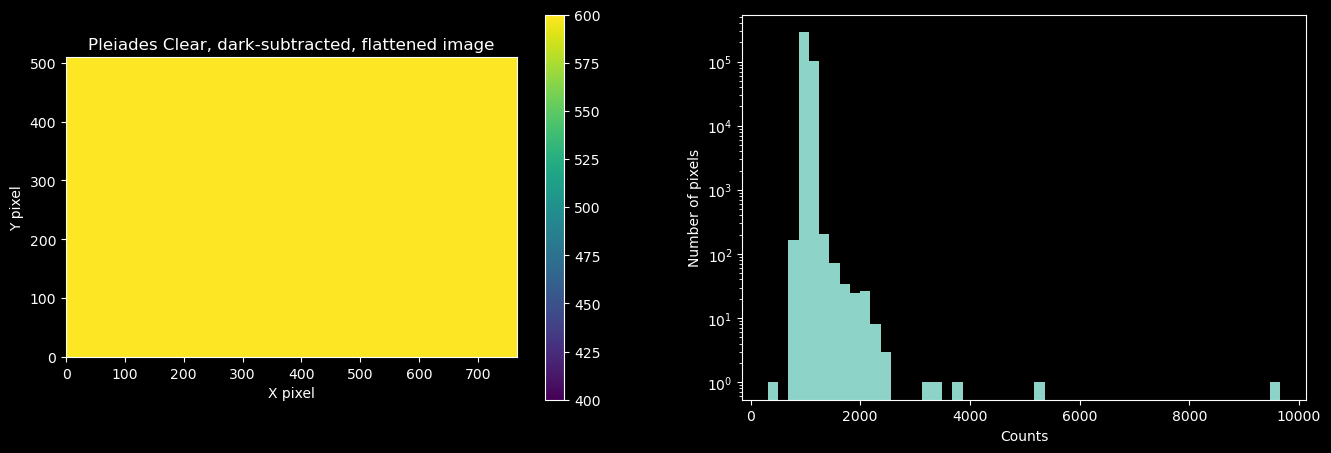

In [6]:
pl.figure(figsize=(16,5))
im = pl.subplot(1,2,1).imshow(pleiades_clear_darksub_flattened, origin='lower', interpolation='none', vmax=600, vmin=400)
pl.colorbar(im)
_=pl.title("Pleiades Clear, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

_ = pl.subplot(1,2,2).hist(pleiades_clear_darksub_flattened.ravel(), bins=50, log=True)
_ = pl.xlabel("Counts")
_ = pl.ylabel("Number of pixels")

And the uncertainty:

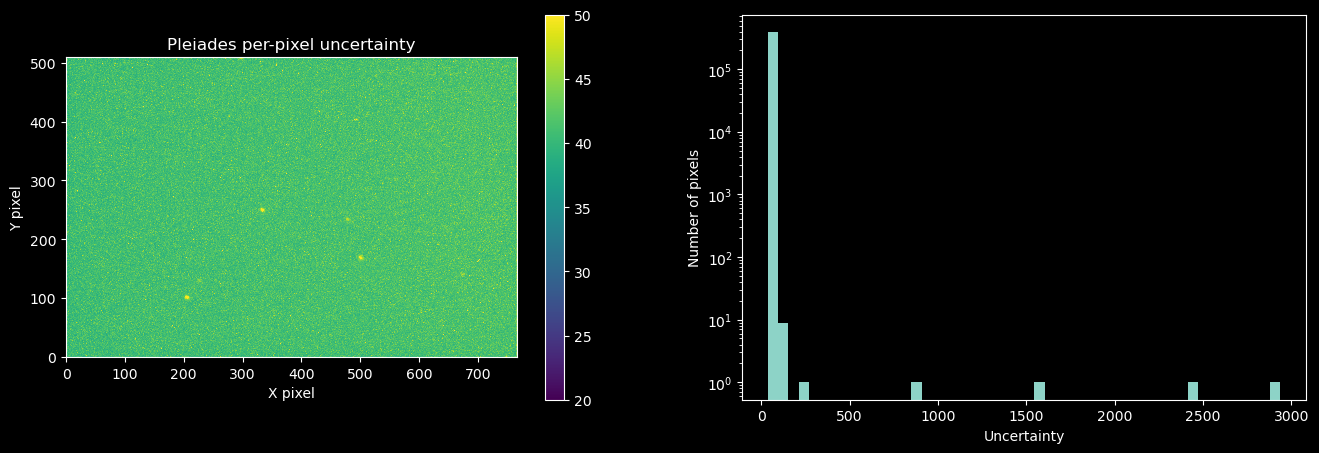

In [7]:
pl.figure(figsize=(16,5))
im = pl.subplot(1,2,1).imshow(pleiades_clear_darksub_flattened_uncertainty,
                              origin='lower', interpolation='none', vmax=50, vmin=20)
pl.colorbar(im)
_=pl.title("Pleiades per-pixel uncertainty")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

_ = pl.subplot(1,2,2).hist(pleiades_clear_darksub_flattened_uncertainty.ravel(), bins=50, log=True)
_ = pl.xlabel("Uncertainty")
_ = pl.ylabel("Number of pixels")

## Photometry

Our next step is to perform some measurements of the stars.

To measure the light from a single star, we need to select only pixels containing that star's light.  

As a first attempt, we can just select a small box containing the star.  You can figure out the size, shape, and location of this box by eyeballing the image above, then iterating a few times to get the right spot.  In other words, you might have started with a box $\sim~$30 pixels on a side centered on $x\sim500$, $y\sim175$, which would be `image[175-15:175+15, 500-15:500+15]`, then gradually changed the center and limits, each time inspecting the image, until you have a tightly-framed box around the star, as below:

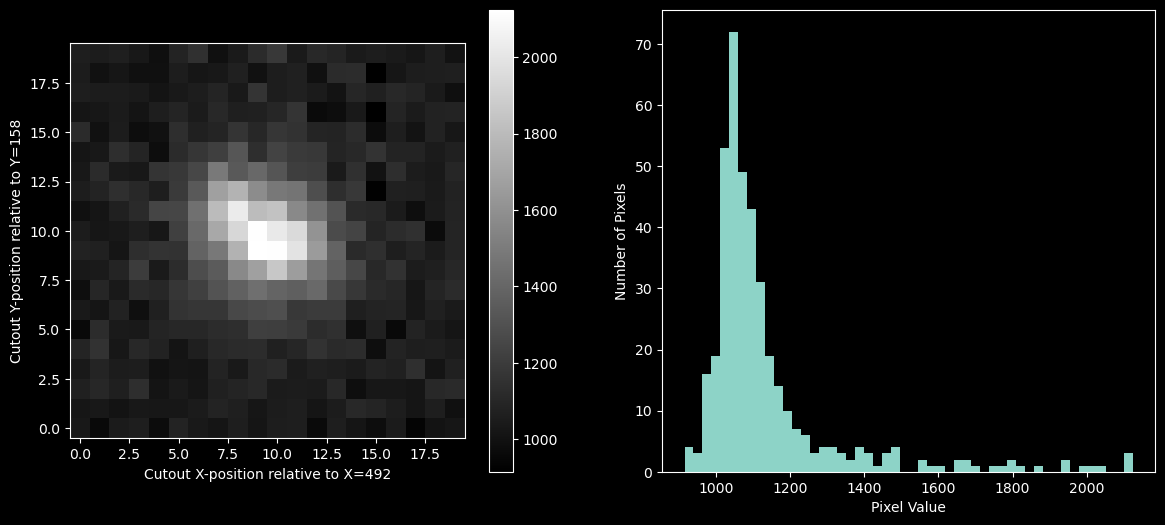

In [8]:
cutout_star = pleiades_clear_darksub_flattened[158:178, 492:512]
pl.figure(figsize=(14,6))
im = pl.subplot(1,2,1).imshow(cutout_star, cmap='gray', origin='lower')
pl.xlabel("Cutout X-position relative to X=492")
pl.ylabel("Cutout Y-position relative to Y=158")
pl.colorbar(im)
_=pl.subplot(1,2,2).hist(cutout_star.ravel(), bins=50)
_=pl.xlabel("Pixel Value")
_=pl.ylabel("Number of Pixels")

The image shows our star, which is a little distorted.  The distortion is most likely from _tracking errors_ in the telescope: it is not rotating exactly correctly to follow the sky.

You should also note that the floor of the image, the lowest observed flux measurement, is not zero.  The floor is closer to ~500. This background is most likely produced by sky contamination.  From CTO, that most likely means scattered light from Gainesville.

To remove this background, we need to obtain an estimate of the sky value.

Because the image is almost entirely sky pixels (the target stars only take up a very small number of them), we can assume that the whole image is effectively an image of the sky background.  We can therefore use the mean (or, more robustly, the median) of the whole image as our sky estimate (but note that this is not possible for all observations - for images of M42, for example, the nebula fills the CCD, so you need separate images to estimate the sky contamination):

In [9]:
sky_mean = pleiades_clear_darksub_flattened.mean()
sky_median = np.median(pleiades_clear_darksub_flattened)
print(sky_mean, sky_median)

1035.2701922573067 1034.4351460591995


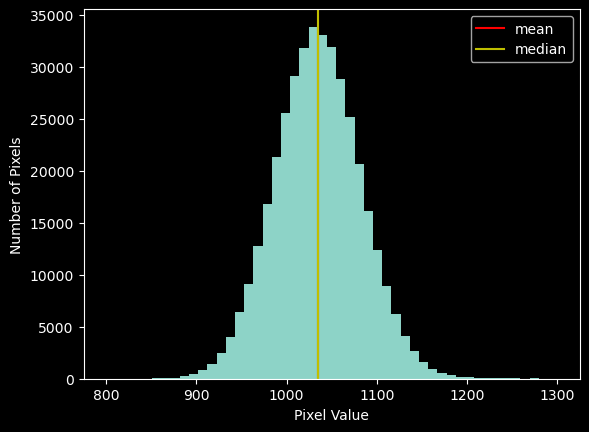

In [10]:
_=pl.hist(pleiades_clear_darksub_flattened.ravel(), bins=np.linspace(800,1300))
_=pl.axvline(sky_mean, color='r', label='mean')
_=pl.axvline(sky_median, color='y', label='median')
_=pl.legend(loc='best')
_=pl.xlabel("Pixel Value")
_=pl.ylabel("Number of Pixels")

These values are nThese values are nearly the same, so we can use either safely.  If the mean and median didn't line up, we would then look for a source of bias - maybe there are outliers that affect the mean, for example.early the same, so we can use either safely.

## Q1
[Index](#Index)

Let's briefly take an aside - what is the uncertainty on this measurement of the sky background?  Recall that the error on the mean, $\sigma_\mu$, is the uncertainty on any individual measurement divided by the number of measurements, i.e.: $\sigma_\mu = \sigma_i / \sqrt{N}$.



Each individual pixel's value is an independent measurement of the sky.  

$$\Sigma_{sky} = \sum x_i$$

The propagation of error formula for sums gives us the error on the sum. 
$$\sigma_{\Sigma}^2 = \sum \sigma_i^2 = N \sigma^2_i$$

 If we assume $\sigma_i$ is constant (every pixel has the same uncertainty), we can simplify this further:

$$\sigma_{\Sigma}^2 = \sum \sigma_i^2 = N \sigma^2_i$$

so
$$\sigma_{\Sigma} = \sqrt{N} \sigma_i$$


We want to calculate the \emph{mean}, which is defined as the sum divided by the number of elements summed over, i.e.:

$$\mu_{sky} = \frac{1}{N} \sum x_i$$

The propagation of error formula gives us, again:
$$\sigma_{\mu}^2 = \frac{1}{N^2} \Sigma \sigma_i^2$$

So we have:

$$\sigma_{\mu} = \left(\frac{1}{N^2} \Sigma \sigma_i^2\right)^{1/2} = \frac{1}{N}\sigma_{\Sigma}$$

which, if we put in $\sigma_{\Sigma}$ from above, gets us to:

$$\sigma_{\mu} = \frac{1}{N}\sigma_{\Sigma} = \frac{\sqrt{N} \sigma_i}{N} = \frac{\sigma_{i}}{\sqrt{N}}$$



We calculated the per-pixel uncertainty, and loaded it into this notebook, from the previous exercise using our usual propagation of error formulae.


In [11]:
# first, let's calculate the error on the _sum_ of all sky pixels
uncertainty_sky_sum = (pleiades_clear_darksub_flattened_uncertainty**2).sum()**0.5
print(f"uncertainty_sky_sum={uncertainty_sky_sum}  (should be 26166.656)")

uncertainty_sky_sum=26166.65562228448  (should be 26166.656)


We have a lot of pixels.  $N$ is:

In [12]:
pleiades_clear_darksub_flattened.size

391170

In [13]:
# given the above, what is the uncertainty on the _mean_ sky estimate?
uncertainty_on_sky_mean = uncertainty_sky_sum / pleiades_clear_darksub_flattened.size
uncertainty_on_sky_mean

0.06689330884854279

In [14]:
print(f"The sky mean is {sky_mean:0.2f} +/- {uncertainty_on_sky_mean:0.2f}.  The SNR={sky_mean/uncertainty_on_sky_mean:0.2g}")

The sky mean is 1035.27 +/- 0.07.  The SNR=1.5e+04


You should find the uncertainty is very small (~0.04-0.05), such that the S/N of our "sky background" measurement is ~10,000.

"`The sky mean is 464.25 +/- 0.05.  The SNR=8.4e+03`"

Note that there are two ways to compute the per-pixel uncertainty: you can follow the error propagation rules we used above or, in cases where you have a lot of pixels independently measuring the same signal (like this case), you can directly estimate the noise from the standard deviation of the data:

In [15]:
sky_stddev = pleiades_clear_darksub_flattened.std() # estimate of the per-pixel error
print(f"Standard deviation of the data: {sky_stddev:0.1f}")
print(f"Average of the per-pixel uncertainty from error propagation: {pleiades_clear_darksub_flattened_uncertainty.mean():0.1f}")

Standard deviation of the data: 53.1
Average of the per-pixel uncertainty from error propagation: 41.3


The per-pixel error is substantial, ~40 and this error will play an important role in our photometry measurements below.

## Q2
[Index](#Index)

Another aside, going back to the atmosphere lecture:  What color will the "sky background" be, and why?  By "color" here, we mean the wavelength of light we measure, and particularly the relative amount of light at different wavelengths.  Credit here is for explaining your reasoning - there are multiple possible correct answers, and we don't know which is correct without measuring.  Bonus points if you come up with multiple mechanisms and can describe a measurement we can perform with our instruments to distinguish between them.

The color of the sky is typically (as we see) blue because of rayleigh scattering where shorter wavelengths of light (blue and violet) are scattered more efficiently than longer wavelgnths like red. We would see this in photometrically by different wavelengths via filters showing a dominance of blue light (around 450-495 nm) in the sky background. If the sky maybe looks a white/grey it could mean dust or pollution dominates as the scattering particles appear the same as light particles making it more uniform. A solution to distinguish the partciles could be using spectroscopic measurements to show a distribution of brightness the visible spectrum which would show a difference from a blue sky seen. If the sky background look orangish that could mean that artificial light is dominating from LEDs lights or others. A spectrometer would pick up a broader spectrum associated with LED lighting and it would look different from blue light scattering.

(back on-topic)


Now, we can subtract that sky value from the image:

In [16]:
sky_subtracted_pleiades_clear = pleiades_clear_darksub_flattened - sky_mean

Now we can look at it again, and we see that the background level is approximately zero:

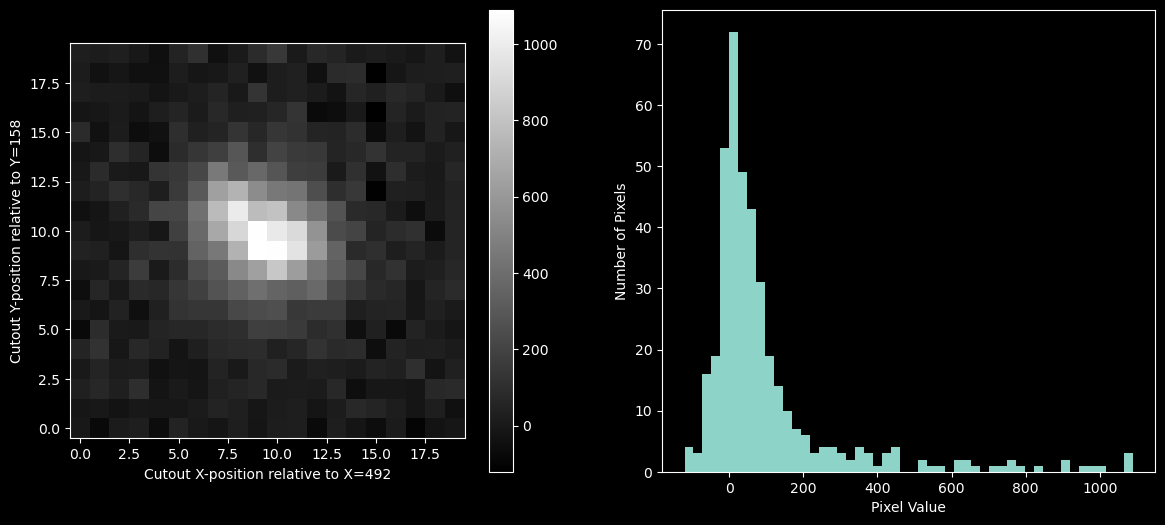

In [17]:
cutout_star = sky_subtracted_pleiades_clear[158:178, 492:512]

pl.figure(figsize=(14,6))
im = pl.subplot(1,2,1).imshow(cutout_star, cmap='gray', origin='lower')
pl.xlabel("Cutout X-position relative to X=492")
pl.ylabel("Cutout Y-position relative to Y=158")
pl.colorbar(im)
_=pl.subplot(1,2,2).hist(cutout_star.ravel(), bins=50)
_=pl.xlabel("Pixel Value")
_=pl.ylabel("Number of Pixels")

Note that the peak of the histogram is near (but not exactly) zero now that we have subtracted off the sky background.  Ideally, it would be exactly zero; the remainder may just be noise or may be scattered light from this star or nearby stars.

So, how much flux is in the star?  We can simply sum over the cutout area we've made:

In [18]:
star_sum = cutout_star.sum()
print(star_sum)

41349.20439526001


We have a flux measurement!  We now need to measure the uncertainty on that measurement.

We can start by noting how many pixels we summed over:

In [19]:
cutout_star.size

400

The error per pixel is, to first order, the same as the error per pixel of the sky background measurement.  There's actually more noise than that because of the higher counts in the star (which increases Poisson noise), but let's start with the sky-based noise estimate.

What contributes to the sky noise $\sigma_{sky}$?  At least three components: 
* read noise
* Poisson noise from dark current
* Poisson noise from the sky.

However, we don't need to know the value of each component, we just need to know the per-pixel uncertainty $\sigma_{sky}$


What is the error on our measurement, then?  It's the error on the sum, which is the sum in quadrature of the errors on the individual measurements.  As long as the error on each pixel is the same, we have:
$$ \sigma_{sum} = \left(\Sigma_i \sigma_i^2\right)^{1/2} = \left(N \sigma_i^2\right)^{1/2} = N^{1/2} \sigma_i$$

In [20]:
star_sum_error = (cutout_star.size * sky_stddev**2)**0.5
star_sum_error

1062.780308450075

Starting with just this source of error, what's our signal-to-noise ratio?

In [21]:
star_sum / star_sum_error

38.90663391718498

That's a signal-to-noise ratio of about 40. 

## Q3
[Index](#Index)

For a signal-to-noise ratio of 40, what is the _approximate_ magnitude error?

Remember the magnitude error is approximately the inverse of the signal-to-noise ratio for small enough uncertainties.

In [22]:
# student answer
mag_err =  1/ (star_sum / star_sum_error)
mag_err

0.025702557618542836

That estimate ignored the Poisson noise from the star.

### Adding Poisson error from the star to the Sky uncertainty

To more accurately determine the error, which is a little larger than that value above, we need to account for the Poisson noise from the star itself.

Recall that the total noise in a pixel has several contributions:
$$ \sigma_{pixel}^2 = \sigma_{readnoise}^2 + \sigma_{dark,Poisson}^2 + \sigma_{sky,Poisson}^2 + \sigma_{star,Poisson}^2$$

We noted before that the sky noise $\sigma_{sky}$ contains contributions from dark, readnoise, and sky, and we have measured it.  We assume that the background noise (sky, dark, and readnoise) is uniform (doesn't change anywhere in our image).  So, given
$$\sigma_{sky}^2 = \sigma_{readnoise}^2 + \sigma_{dark,Poisson}^2 + \sigma_{sky,Poisson}^2$$
we can substitute our measured $\sigma_{sky}$ in the first equation above to get:
$$ \sigma_{pixel}^2 = \sigma_{sky}^2 + \sigma_{star,Poisson}^2$$

Since we've already measured $\sigma_{sky}$, we only need to measure $\sigma_{star,Poisson}$, which we can obtain from $\sqrt{\lambda}$, i.e., the square root of the number of counts.  In other words, $\sigma_{star,Poisson}^2 = n_{counts}$

Recall that the `cutout_star` image should now consist only of starlight measurement, with no contribution from dark, bias, or sky background since we subtracted off the bias and sky background previously.  That means that each pixel is a measurement of the number of counts (if you account for the gain), which is the squared error.

The operation below measures the error on _each pixel_:

In [23]:
# we re-load the gain as a reminder, but if we did the dark subtraction and flattening right, we already accounted for the gain
gain = fits.getheader('pleiades_30s_C_other_001_darksub_flattened.fits')['EGAIN']
gain

2.23

In [24]:
# we just rename the variable to make more clear that the "cutout" contains electron counts
per_pixel_electron_counts_star_cutout = cutout_star

In [25]:
per_pixel_error = (per_pixel_electron_counts_star_cutout + sky_stddev**2)**0.5

So, now what is the true total error?  Again we simply sum in quadrature ($\sigma^2_\Sigma = \Sigma \sigma_i^2$):

In [26]:
total_star_sum_error = (per_pixel_error**2).sum()**0.5
total_star_sum_error

1082.0587730915988

That error is only a little larger than the previous one.  

Noting the _peak counts_ (the brightest pixel) in the star are ~1000:

In [27]:
cutout_star.max()

1089.3864524679964

# Q4
[Index](#Index)

Explain why the error when including the Poisson noise from the star is only a little larger than the error when _not_ including it.  

Hint: How many photons did you get from the star in the brightest pixel?  How many photons did you get from the sky (background) in that same pixel?

This is because the Poisson noise is proportional to the square root of the number of photons, so the background noise (with its much higher photon count) dominates the total uncertainty. The additional noise from the star has a small effect on the overall error because of it.


In the end, we have a measurement $S_* = 41300 \pm 1100$ with SNR = 38

In [28]:
# I used this print statement to get the above answer
# int() converts a float measurement to an integer - so instead of printing 41000.0, it prints 41000
# np.around is a rounding tool.  I told the code to round each of the numbers to have the correct significant figures
# (we estimated that the error has two significant figures, but we matched the star counts to the error's number
# of significant figures)
print(f"In the end, we have a measurement $S_* = {int(np.round(star_sum, -2))} +/- {int(np.around(total_star_sum_error,-2))}$"
      f" with SNR = {int(np.around(star_sum / total_star_sum_error, 0))}")

In the end, we have a measurement $S_* = 41300 +/- 1100$ with SNR = 38


## Optimizing our Measurement
[Index](#Index)


However, note that this is not an optimal measurement.  We included _noise_ from many pixels that did not contain any signal, thereby reducing our signal-to-noise ratio.  

We can improve this measurement by excluding the pixels that only contribute noise and do not contribute signal.

To figure out which pixels these are, we can apply a signal-to-noise threshold.  

We know the typical per-pixel noise is $\sim 50$ counts, so if we include only pixels $S>2\sigma$ ($S>100$ counts), we might see only the star.  Note that $2\sigma$ is an arbitrary threshold - different thresholds ($3\sigma$, $5\sigma$, etc) may be more appropriate in other situations.

In the next plot, we'll overlay _contours_ selecting the region with $S>2\sigma$:

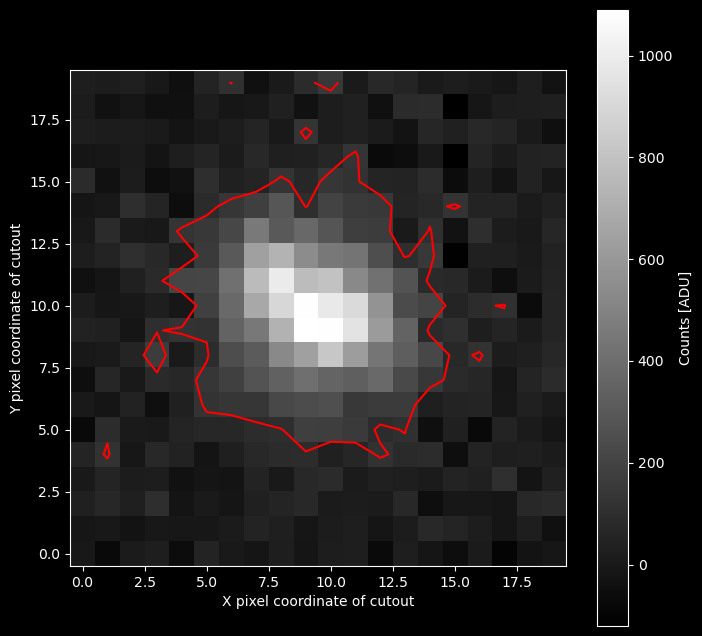

In [29]:
pl.figure(figsize=(8,8))
im = pl.imshow(cutout_star, cmap='gray', origin='lower')
cb = pl.colorbar(im)
cb.set_label("Counts [ADU]")
pl.contour(cutout_star, levels=[2*sky_stddev], colors=['r'])
_=pl.xlabel("X pixel coordinate of cutout")
_=pl.ylabel("Y pixel coordinate of cutout")

We can create a _mask_ to select only pixels above the threshold:

In [30]:
mask = cutout_star > 2*sky_stddev

The `mask` is a _boolean array mask_, in which each pixel is either `True` or `False`.

If you multiply another number by a boolean, like `5*True` or `3*False`, they are treated as `True=1`, `False=0`.

Both of these are shown in the next figure:

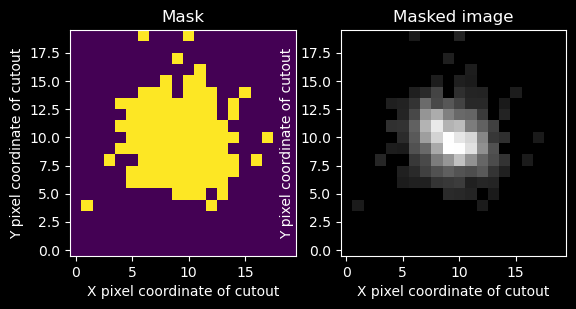

In [31]:
pl.subplot(1,2,1).imshow(mask)
pl.title("Mask")
_=pl.xlabel("X pixel coordinate of cutout")
_=pl.ylabel("Y pixel coordinate of cutout")
pl.subplot(1,2,2).imshow(cutout_star*mask, cmap='gray')
pl.title("Masked image")
_=pl.xlabel("X pixel coordinate of cutout")
_=pl.ylabel("Y pixel coordinate of cutout")

We can sum over only the included pixels now (those where `mask==True`), and compute the noise for only these pixels.

In [32]:
masked_star_sum = cutout_star[mask].sum()
print(f"Masked star sum = {masked_star_sum:0.1f}, "
      f"{-(masked_star_sum-star_sum)/star_sum*100:0.1f} percent less than {star_sum:0.1f}")

Masked star sum = 35316.2, 14.6 percent less than 41349.2


Since we summed over a smaller area, we also have a smaller contribution of sky noise.  We repeat the total error calculation we made above, but now using only masked pixels.  Note that `mask.sum()` is the number of pixels included in the mask:

In [33]:
masked_star_sum_error = (cutout_star[mask].sum() + sky_stddev**2*mask.sum())**0.5
print(masked_star_sum_error)

563.6414354273203


In [34]:
print(f"For the masked sum, we obtain $S_* = {int(np.round(masked_star_sum, -2))} +/- {int(np.around(masked_star_sum_error,-2))}$"
      f" with SNR = {int(np.around(masked_star_sum / masked_star_sum_error, 0))}")


For the masked sum, we obtain $S_* = 35300 +/- 600$ with SNR = 63



The new value for the sum is quite a bit different from the original, but it includes all the flux from the star.  
The signal-to-noise ratio is higher because we didn't include as much noise.


## Systematic Errors
[Index](#Index)

That extra 15% in the original measurement may come from several possible sources: 
 * Background stars that are too faint to see individually
 * Localized sky emission that is different from the mean (this is unlikely to be significant)
 * Localized nebular emission or reflected emission
 * Inadequately-corrected flat-field effects
 * Pixels containing some star flux that were excluded because they are below the threshold (this effect is often corrected using an _aperture correction_, which accounts for a well-understood point-spread-function [PSF])
 
Depending on how accurate we need our measurements to be, we may need to account for these errors.  Flux loss errors like this are generally called _systematic errors_ because they operate in only one direction (in this case, lower flux, not higher), as opposed to measurement errors that are _random_ and tend to average to zero.

To search for systematic errors, we can examine our data more closely:

Mean of 'background' region: 20.1, Sum of 'background' region: 6033.0


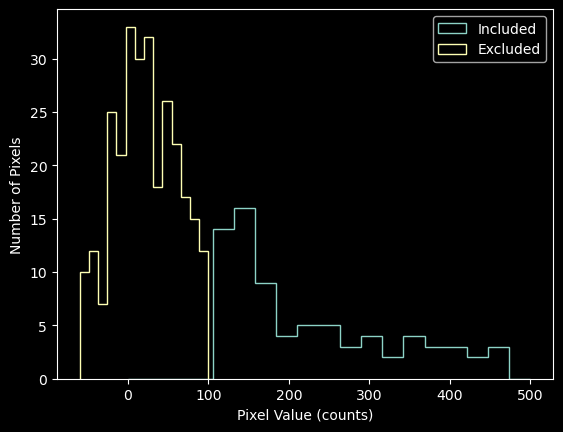

In [35]:
_=pl.hist(cutout_star[mask], bins=np.linspace(0,500,20), label='Included', histtype='step')
_=pl.hist(cutout_star[~mask], bins=np.linspace(-60,100,15), label='Excluded', histtype='step')
_=pl.legend()
_=pl.xlabel("Pixel Value (counts)")
_=pl.ylabel("Number of Pixels")
print(f"Mean of 'background' region: {cutout_star[~mask].mean():0.1f}, "
      f"Sum of 'background' region: {cutout_star[~mask].sum():0.1f}")

We can see from the above histogram and arithmetic that the background pixels have a non-zero mean.  

If you refer back to the [original](#Step-1:-Load-the-data) full image, you can see that there was a leftover gradient in the background. This un-subtracted background, whose origin we do not yet know, is likely the cause of the excess background light.  Note this sort of feature during your reduction, you'll have to explain it!

### Masked SNR
[Index](#Index)

Finally, we return to the masked sum and SNR calculation:

In [36]:
print(f"Masked measurement is {masked_star_sum:0.1f} +/- {masked_star_sum_error:0.1f}"
      f" for SNR={masked_star_sum/masked_star_sum_error:0.1f}")

Masked measurement is 35316.2 +/- 563.6 for SNR=62.7


By masking appropriately, we can increase the signal-to-noise ratio substantially.

However, be wary!  If, by masking, you exclude some pixels with signal from the star, you will measure its flux inaccurately!  You may end up with a _biased_ flux measurement, which can lead to erroneous conclusions!

This masked measurement is still not the _optimal_ measurement you can make.  If you know precisely the shape of the PSF, you can perform _optimal extraction_ as part of _PSF photometry_.  We will not do that here, as it requires many additional steps, but we may come back later.

## Photometry - not just single-star!
[Index](#Index)

Now, we need to repeat that exercise for some other stars.  We'll be terser this time through:

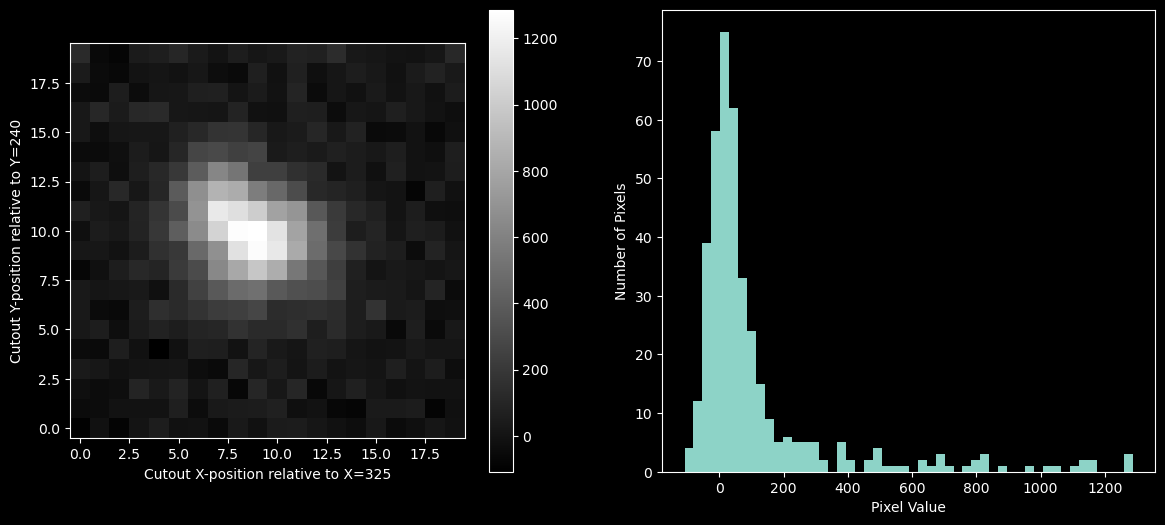

In [37]:
cutout_star2 = sky_subtracted_pleiades_clear[240:260, 325:345, ]
pl.figure(figsize=(14,6))
im = pl.subplot(1,2,1).imshow(cutout_star2, cmap='gray', origin='lower')
pl.xlabel("Cutout X-position relative to X=325")
pl.ylabel("Cutout Y-position relative to Y=240")
pl.colorbar(im)
_=pl.subplot(1,2,2).hist(cutout_star2.ravel(), bins=50)
_=pl.xlabel("Pixel Value")
_=pl.ylabel("Number of Pixels")

In [38]:
print(f"Star 2 measurement is {cutout_star2.sum():0.1f} +/- {(cutout_star2+sky_stddev**2).sum()**0.5:0.1f}"
      f"(SNR = {cutout_star2.sum()/(cutout_star2+sky_stddev**2).sum()**0.5:0.1f})")

Star 2 measurement is 45902.4 +/- 1084.2(SNR = 42.3)


In [39]:
mask2 = cutout_star2 > 2*sky_stddev
masked_star_sum2 = cutout_star2[mask2].sum()
masked_star_sum_error2 = (cutout_star2[mask2].sum() + sky_stddev**2*mask2.sum())**0.5
print(f"Masked measurement for star 2 is {masked_star_sum2:0.1f} +/- {masked_star_sum_error2:0.1f}"
      f" for SNR={masked_star_sum2/masked_star_sum_error2:0.1f}")

Masked measurement for star 2 is 40898.4 +/- 563.6 for SNR=72.6


## Exercise: Obtain flux measurements for two more stars

[Index](#Index)

Follow the process described above to obtain flux measurements for two additional stars.  Identify them yourself from the image and print out the measurement and the signal-to-noise ratio as we did above.

Compare the SNR you obtain for your star to the SNR we obtained above.  Is it what you expect?  (Hint: we expect a higher signal-to-noise ratio for a brighter star in the same image)

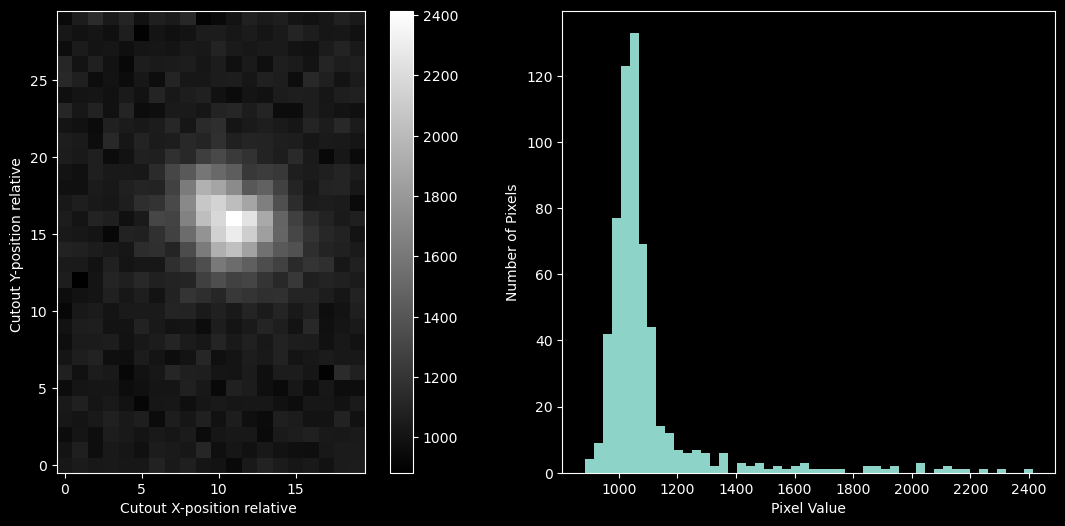

In [86]:
#star 1

cutout_star1 = pleiades_clear_darksub_flattened[85:115, 195:215]
pl.figure(figsize=(14,6))
im = pl.subplot(1,2,1).imshow(cutout_star1, cmap='gray', origin='lower')
pl.xlabel("Cutout X-position relative ")
pl.ylabel("Cutout Y-position relative ")
pl.colorbar(im)
_=pl.subplot(1,2,2).hist(cutout_star1.ravel(), bins=50)
_=pl.xlabel("Pixel Value")
_=pl.ylabel("Number of Pixels")

In [44]:
cutout_star1 = sky_subtracted_pleiades_clear[85:115, 195:215]
star_sum_error1 = (cutout_star1.size * sky_stddev**2)**0.5
star_sum_error1

1301.6347321902

In [45]:
SNR= star_sum / star_sum_error1
mag_err =  1/ (star_sum / star_sum_error1)
mag_err

0.031479075624957144

In [48]:
per_pixel_electron_counts_star_cutout1 = cutout_star1
per_pixel_error = (per_pixel_electron_counts_star_cutout1 + sky_stddev**2)**0.5

total_star_sum_error = (per_pixel_error**2).sum()**0.5
total_star_sum_error

1316.7344895466142

In the end, we have a measurement $S_* = 41300 +/- 1300$ with SNR = 31


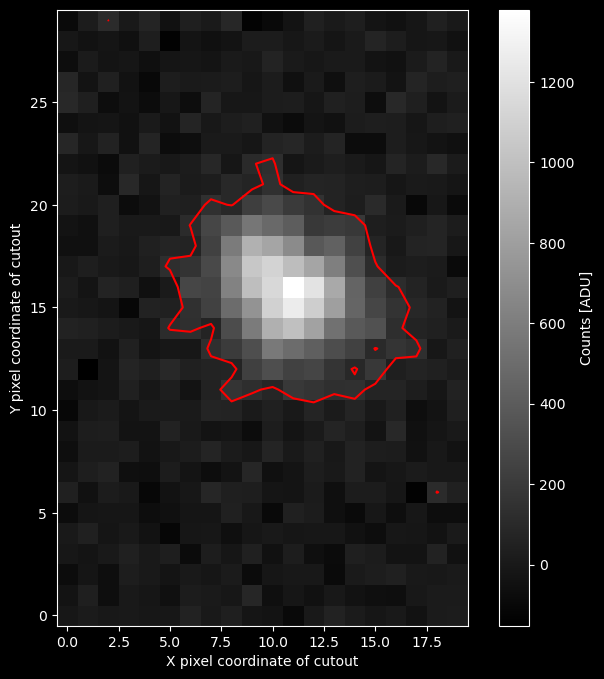

In [51]:
print(f"In the end, we have a measurement $S_* = {int(np.round(star_sum, -2))} +/- {int(np.around(total_star_sum_error,-2))}$"
      f" with SNR = {int(np.around(star_sum / total_star_sum_error, 0))}")


pl.figure(figsize=(8,8))
im = pl.imshow(cutout_star1, cmap='gray', origin='lower')
cb = pl.colorbar(im)
cb.set_label("Counts [ADU]")
pl.contour(cutout_star1, levels=[2*sky_stddev], colors=['r'])
_=pl.xlabel("X pixel coordinate of cutout")
_=pl.ylabel("Y pixel coordinate of cutout")

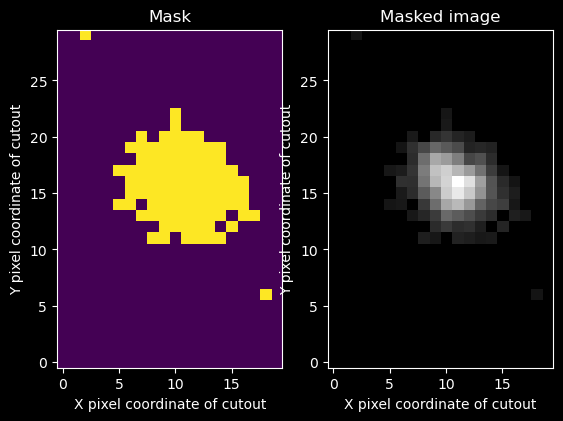

In [52]:
mask1 = cutout_star1 > 2*sky_stddev

pl.subplot(1,2,1).imshow(mask1)
pl.title("Mask")
_=pl.xlabel("X pixel coordinate of cutout")
_=pl.ylabel("Y pixel coordinate of cutout")
pl.subplot(1,2,2).imshow(cutout_star1*mask1, cmap='gray')
pl.title("Masked image")
_=pl.xlabel("X pixel coordinate of cutout")
_=pl.ylabel("Y pixel coordinate of cutout")

In [54]:
masked_star_sum = cutout_star1[mask1].sum()
print(f"Masked star sum = {masked_star_sum:0.1f}, "
      f"{-(masked_star_sum-star_sum)/star_sum*100:0.1f} percent less than {star_sum:0.1f}")

masked_star_sum_error = (cutout_star1[mask1].sum() + sky_stddev**2*mask1.sum())**0.5
print(masked_star_sum_error)

Masked star sum = 39734.4, 3.9 percent less than 41349.2
547.2841126498587


For the masked sum, we obtain $S_* = 39700 +/- 500$ with SNR = 73
Mean of 'background' region: -0.4, Sum of 'background' region: -197.7
Masked measurement is 39734.4 +/- 547.3 for SNR=72.6


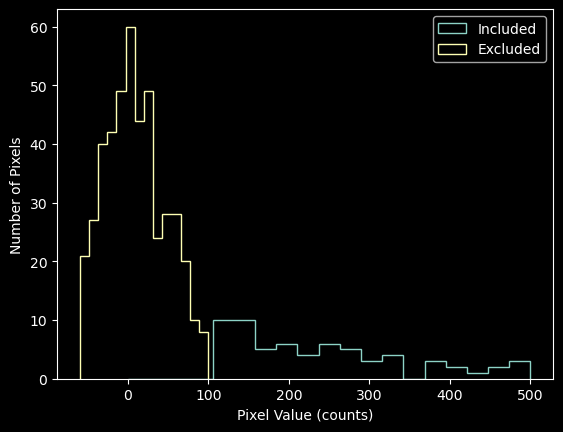

In [57]:
print(f"For the masked sum, we obtain $S_* = {int(np.round(masked_star_sum, -2))} +/- {int(np.around(masked_star_sum_error,-2))}$"
      f" with SNR = {int(np.around(masked_star_sum / masked_star_sum_error, 0))}")

_=pl.hist(cutout_star1[mask1], bins=np.linspace(0,500,20), label='Included', histtype='step')
_=pl.hist(cutout_star1[~mask1], bins=np.linspace(-60,100,15), label='Excluded', histtype='step')
_=pl.legend()
_=pl.xlabel("Pixel Value (counts)")
_=pl.ylabel("Number of Pixels")
print(f"Mean of 'background' region: {cutout_star1[~mask1].mean():0.1f}, "
      f"Sum of 'background' region: {cutout_star1[~mask1].sum():0.1f}")

print(f"Masked measurement is {masked_star_sum:0.1f} +/- {masked_star_sum_error:0.1f}"
      f" for SNR={masked_star_sum/masked_star_sum_error:0.1f}")

In [136]:
#The previous star in the beginning had a masked sum SNR of 63 and this other star had an SNR of 73. 
#This was expected.

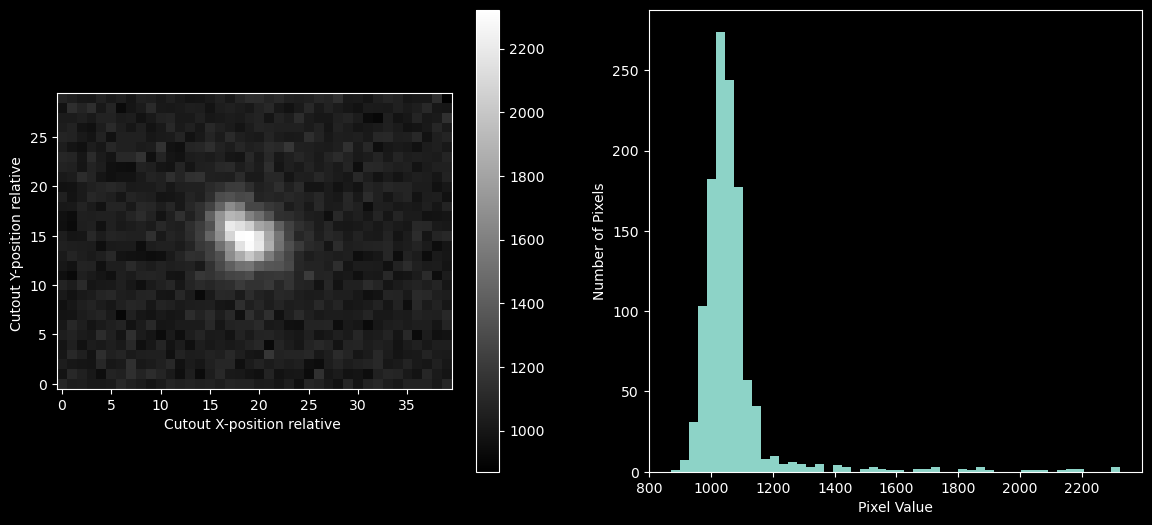

In [141]:
#star 2
cutout_star3 = pleiades_clear_darksub_flattened[235:265, 315:355]
pl.figure(figsize=(14,6))
im = pl.subplot(1,2,1).imshow(cutout_star3, cmap='gray', origin='lower')
pl.xlabel("Cutout X-position relative ")
pl.ylabel("Cutout Y-position relative ")
pl.colorbar(im)
_=pl.subplot(1,2,2).hist(cutout_star3.ravel(), bins=50)
_=pl.xlabel("Pixel Value")
_=pl.ylabel("Number of Pixels")

In [142]:
star_sum_error2 = (cutout_star3.size * sky_stddev**2)**0.5
star_sum_error2

1840.7894915192526

In [143]:
SNR= star_sum / star_sum_error2
mag_err =  1/ (star_sum / star_sum_error2)
mag_err

0.04451813567978271

In [144]:
per_pixel_electron_counts_star_cutout2 = cutout_star3
per_pixel_error = (per_pixel_electron_counts_star_cutout2 + sky_stddev**2)**0.5

total_star_sum_error = (per_pixel_error**2).sum()**0.5
total_star_sum_error

2162.624975616459

In the end, we have a measurement $S_* = 41300 +/- 2200$ with SNR = 19


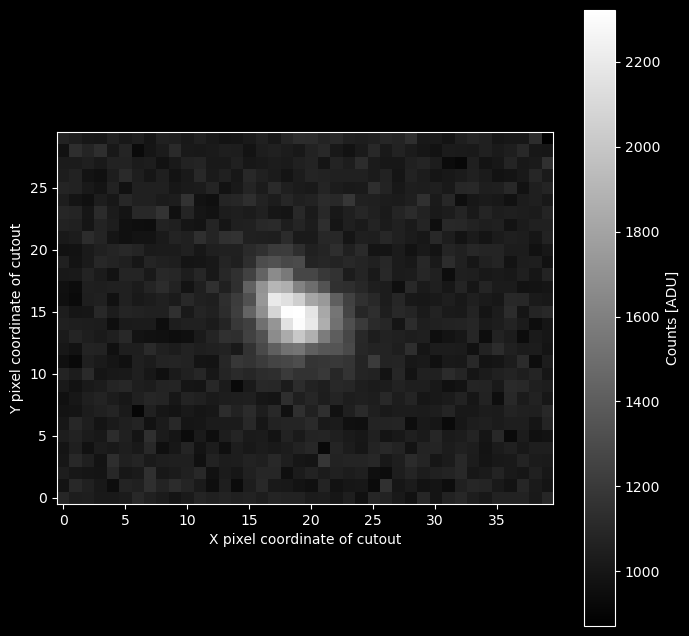

In [145]:
print(f"In the end, we have a measurement $S_* = {int(np.round(star_sum, -2))} +/- {int(np.around(total_star_sum_error,-2))}$"
      f" with SNR = {int(np.around(star_sum / total_star_sum_error, 0))}")

pl.figure(figsize=(8,8))
im = pl.imshow(cutout_star3, cmap='gray', origin='lower')
cb = pl.colorbar(im)
cb.set_label("Counts [ADU]")
pl.contour(cutout_star3, levels=[1.5*sky_stddev], colors=['r'])
_=pl.xlabel("X pixel coordinate of cutout")
_=pl.ylabel("Y pixel coordinate of cutout")

In [146]:
mask2 = cutout_star3 > 1.5*sky_stddev

masked_star_sum = cutout_star3[mask2].sum()

masked_star_sum_error = (cutout_star3[mask2].sum() + sky_stddev**2*mask2.sum())**0.5
print(masked_star_sum_error)

2162.624975616459


In [147]:
print(f"For the masked sum, we obtain $S_* = {int(np.round(masked_star_sum, -2))} +/- {int(np.around(masked_star_sum_error,-2))}$"
      f" with SNR = {int(np.around(masked_star_sum / masked_star_sum_error, 0))}")

print(f"Mean of 'background' region: {cutout_star3[~mask2].mean():0.1f}, "
      f"Sum of 'background' region: {cutout_star3[~mask2].sum():0.1f}")

print(f"Masked measurement is {masked_star_sum:0.1f} +/- {masked_star_sum_error:0.1f}"
      f" for SNR={masked_star_sum/masked_star_sum_error:0.1f}")


For the masked sum, we obtain $S_* = 1288400 +/- 2200$ with SNR = 596
Mean of 'background' region: nan, Sum of 'background' region: 0.0
Masked measurement is 1288440.8 +/- 2162.6 for SNR=595.8


/var/folders/ct/3p6ngzhj6xbcrqtyd_rkdsn00000gn/T/ipykernel_1667/1252411713.py:4: RuntimeWarning: Mean of empty slice.
  print(f"Mean of 'background' region: {cutout_star3[~mask2].mean():0.1f}, "


In [148]:
#The star this time has an extremely high SNR! Almost triple to original of 63.
#This was expected but not to such a high extent.

## Programming more efficiently
[Index](#Index)

An earlier version of this notebook included some typos in one of the cells above.  I had `cutout_star2[mask]` instead of `cutout_star2[mask2]`.  

This is the sort of programming error that occurs frequently when you copy and paste code.  Generally, if you're copying and pasting, there's a better way!

One of the most important programming concepts is `functions`.  These are, very coarsely and broadly, ways to effectively copy & paste code without copying & pasting.

If you have any operation that you want to repeat exactly, or repeat changing only a small thing (say, a coordinate...), you can write a function to do that.

In  this case, we want a function to measure the star's flux and the error on the star's flux.   We can do this by... well, copying and pasting what we did at first, but now generalizing.

The function will take some inputs and give some outputs.  It helps to start by defining what those are (though we can modify that as we go).  We know we want the two measured values, so we can start with those:

```
def calculate_star_flux_and_error(inputs):
    return masked_star_sum, masked_star_sum_error
```

Once we know what we want, we can work backwards to see what we need to do to get it.  We need to have the _cutout_ and the _mask_:

```
def calculate_star_flux_and_error(inputs):
    mask = cutout_star > 2*sky_stddev
    masked_star_sum = cutout_star[mask].sum()
    masked_star_sum_error = (cutout_star[mask].sum() + sky_stddev**2*mask.sum())**0.5
 
    return masked_star_sum, masked_star_sum_error
```

So what variables does the function need?  The undefined ones: at least the `sky_stddev` and the `cutout_star`.  However, both of these are derived from the parent image: really, we only need the parent image, then we can calculate both.

This is how we calculated the cutout and the stddev:
```
    cutout_star = pleiades_clear_darksub_flattened[158:178, 492:512]

    sky_stddev = pleiades_clear_darksub_flattened.std()
```


We can give those as inputs to the function, and now we have a working function:

In [138]:
def calculate_star_flux_and_error(cutout_star, sky_stddev):

    mask = cutout_star > 2*sky_stddev
    masked_star_sum = cutout_star[mask].sum()
    masked_star_sum_error = (cutout_star[mask].sum() + sky_stddev**2*mask.sum())**0.5
 
    return masked_star_sum, masked_star_sum_error

In [139]:
calculate_star_flux_and_error(cutout_star, sky_stddev)

(39734.443632218936, 547.2841126498587)

Now that we have this function, it's pretty easy to repeat our measurement for the second star:

In [140]:
calculate_star_flux_and_error(cutout_star2, sky_stddev)

(1288440.8330723806, 2162.624975616459)

# Exercise: Use the function to repeat the exercise on another two stars
[Index](#Index)

In [149]:
calculate_star_flux_and_error(cutout_star1, sky_stddev) #first star

(660698.8552721126, 1534.5852310367015)

In [151]:
calculate_star_flux_and_error(cutout_star3, sky_stddev) #second star

(1288440.8330723806, 2162.624975616459)